In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os, sys, glob
import matplotlib.pyplot as plt
import xarray as xr
import cftime
from matplotlib.backends.backend_pdf import PdfPages
import warnings

import cartopy.crs as ccrs
def set_background(ax):
    ax.set_extent([-121, -72, 25, 50])

    # Background boundaries
    # ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray')
    
    return ax

warnings.filterwarnings('ignore')


# observed streamflow
def read_CAMELS_Q(file_Qobs):
    df_q_in = pd.read_csv(file_Qobs, delim_whitespace=True, header=None)
    years = df_q_in[1].values
    months = df_q_in[2].values
    days = df_q_in[3].values
    dates = [f'{years[i]}-{months[i]:02}-{days[i]:02}' for i in range(len(years))]
    dates = pd.to_datetime(dates)
    q_obs = df_q_in[4].values * 0.028316847  # cfs to cms
    q_obs[q_obs < 0] = -9999.0
    df_q_out = pd.DataFrame({'Date': dates, 'Runoff_cms': q_obs})
    
    # fill possible missing values
    df_q_out.set_index('Date', inplace=True)
    date_range = pd.date_range(start=dates[0], end=dates[-1], freq='D')
    df_q_out = df_q_out.reindex(date_range)
    df_q_out.fillna(-9999, inplace=True)
    df_q_out.reset_index(inplace=True)
    df_q_out = df_q_out.rename(columns={'index': 'Date'})

    return df_q_out
    


# Convert the datetime64 time axis of ds_qobs to cftime.DatetimeNoLeap
def convert_time_to_cftime(ds):
    # First, convert the datetime64 objects to pandas Timestamps to access year, month, etc.
    time_values = pd.to_datetime(ds['time'].values)

    # Convert to cftime.DatetimeNoLeap objects
    cftime_no_leap_time = [cftime.DatetimeNoLeap(t.year, t.month, t.day, t.hour, t.minute, t.second)
                           for t in time_values]
    
    # Replace the time coordinate in ds with the new cftime time axis
    ds = ds.assign_coords(time=cftime_no_leap_time)
    
    return ds


def find_max_kge(file_pattern):
    """
    This function takes a file pattern (glob-style) to find the CSV files containing the 'kge' column.
    It returns the iteration number and row number (index) where the maximum KGE is found across all CSV files.
    
    Parameters:
    file_pattern (str): The file path pattern to match the CSV files.

    Returns:
    tuple: (best_iter, best_row_index) where the max KGE is found.
    """
    # Get all CSV files matching the pattern
    csv_files = glob.glob(file_pattern)
    
    # Initialize variables to track the maximum KGE and its location
    max_kge = -float('inf')  # Set an initial value smaller than any KGE value
    best_iter = None
    best_row_index = None
    
    # Loop over each CSV file
    for file in csv_files:
        # Read the CSV file
        df = pd.read_csv(file)
        
        # Check if 'kge' column exists in the DataFrame
        if 'kge' in df.columns:
            # Find the maximum KGE value in the current file
            current_max_kge = df['kge'].max()
            
            # If this max KGE is larger than the global max, update the tracking variables
            if current_max_kge > max_kge:
                max_kge = current_max_kge
                best_iter = file.split('/')[-1].split('_')[0]  # Extract iteration from the filename
                best_row_index = df['kge'].idxmax()  # Get the index (row) where the max KGE occurs
    
    return best_iter, best_row_index



def read_flow_data(basin, df_info):
    # basin = 1

    # year=2010
    year='' # all years
    
    file = f'/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/disaggregation/surfdata_CAMELS_level1_hist_78pfts_CMIP6_simyr2000_HAND_trapezoidal_{basin}.nc'
    ds_surf = xr.load_dataset(file)
    mesharea = ds_surf.AREA.values
    
    # clm runoff: default
    flag = 'iter0_trial0'
    inpath = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/level1_{basin}_calib/ctsm_outputs/{flag}/lnd/hist'
    files = glob.glob(f'{inpath}/level1_*.clm2.h1.{year}*.nc')
    files.sort()
    ds_clm = xr.open_mfdataset(files, decode_times=True)
    ds_clm = ds_clm[['QRUNOFF']]
    ds_clm['QRUNOFF'].values = (ds_clm['QRUNOFF'].values / 1000) * (mesharea * 1e6)  # Convert to correct units
    ds_clm = ds_clm.QRUNOFF
    ds_clm = ds_clm.isel(time=slice(365,None))
    
    # clm runoff: calibrated
    file_pattern = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/level1_{basin}_calib/ctsm_outputs_LSEnormKGE/iter*_many_metrics_mizuroute_s-1.csv'
    best_iter, best_row_index = find_max_kge(file_pattern)
    inpath = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator/level1_{basin}_calib/ctsm_outputs_LSEnormKGE/{best_iter}_trial{best_row_index}/lnd/hist/'
    files = glob.glob(f'{inpath}/level1_*.clm2.h1.{year}*.nc')
    files.sort()
    ds_clm_optmz = xr.open_mfdataset(files, decode_times=True)
    ds_clm_optmz = ds_clm_optmz[['QRUNOFF']]
    ds_clm_optmz['QRUNOFF'].values = (ds_clm_optmz['QRUNOFF'].values / 1000) * (mesharea * 1e6)  # Convert to correct units
    ds_clm_optmz = ds_clm_optmz.QRUNOFF
    ds_clm_optmz = ds_clm_optmz.isel(time=slice(365,None))
    
    # obs
    id = df_info.iloc[basin]['hru_id']
    file = f'/glade/work/guoqiang/CTSM_CAMELS/CAMLES_Qobs/{id:08}_streamflow_qc.txt'
    df_qobs = read_CAMELS_Q(file)

    df_qobs = df_qobs[ (df_qobs['Date']>= ds_clm.time.values[0].strftime('%Y-%m-%d')) & (df_qobs['Date']<= ds_clm.time.values[-1].strftime('%Y-%m-%d')) ]

    df_qobs['Date'] = pd.to_datetime(df_qobs['Date'])  # Ensure Date is in datetime format
    df_qobs = df_qobs[~((df_qobs['Date'].dt.month == 2) & (df_qobs['Date'].dt.day == 29))]
    df_qobs

    # Convert df_qobs to xarray DataArray
    d = df_qobs['Runoff_cms'].values
    d[d<0]=np.nan
    da_qobs = xr.DataArray(d,
                           dims='time',
                           coords={'time': df_qobs['Date'].values},
                           name='Runoff_cms')
    da_qobs = convert_time_to_cftime(da_qobs)
    
    return ds_clm, ds_clm_optmz, da_qobs

def calculate_monthly_means(ds):
    # (1) Monthly mean for each month (e.g., Jan 2000, Feb 2000, ..., Dec 2010)
    monthly_mean = ds.resample(time='1M').mean()

    # (2) Monthly climatology (average over all Januarys, all Februarys, etc.)
    monthly_climatology = ds.groupby('time.month').mean('time')
    
    return monthly_mean, monthly_climatology



In [5]:
# basin info
file = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(file)

file = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info_supplment.csv'
df_info2 = pd.read_csv(file)

df_info['name'] = df_info2['station_nm']

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

# Function to generate KGE metrics for the basin
def get_kge_metrics(basin, path0, files, types):
    kge = []
    for j in range(len(types)):
        fileij = f'{path0}/level1_{basin}_calib/ctsm_outputs/iter0_trial0/{files[j]}'
        if os.path.isfile(fileij):
            dfij = pd.read_csv(fileij)
            kge.append(dfij['kge'].values[0])
        else:
            kge.append(np.nan)
    return kge

# Function to read flow data and calculate monthly means
def process_basin_data(basin, df_info):
    # Read flow data
    ds_clm, ds_clm_optmz, ds_qobs = read_flow_data(basin, df_info)
    
    # Calculate monthly means
    ds_clm_m1, ds_clm_m2 = calculate_monthly_means(ds_clm)
    ds_clm_optmz_m1, ds_clm_optmz_m2 = calculate_monthly_means(ds_clm_optmz)
    ds_qobs_m1, ds_qobs_m2 = calculate_monthly_means(ds_qobs)
    
    return ds_clm, ds_clm_optmz, ds_qobs, ds_clm_m1, ds_clm_m2, ds_clm_optmz_m1, ds_clm_optmz_m2, ds_qobs_m1, ds_qobs_m2



# Function to plot the results for each basin
def plot_basin_data(basin, df_info, ds_clm, ds_clm_optmz, ds_qobs, 
                    ds_clm_m1, ds_clm_m2, ds_clm_optmz_m1, ds_clm_optmz_m2, 
                    ds_qobs_m1, ds_qobs_m2,):

    # Load the shapefile using geopandas
    shapefile_path = '/glade/u/home/guoqiang/CTSM_repos/CTSM_calibration/data/CONUS_shp/cb_2018_us_state_5m.shp'
    us_shapefile = gpd.read_file(shapefile_path)
    
    conus_shapefile = us_shapefile[~us_shapefile['STUSPS'].isin(['HI', 'AK'])]

    fig = plt.figure(figsize=[10, 10])

    # Plot location
    ax = fig.add_subplot(3, 2, 1)

    # Set the lat/lon range for the CONUS region
    ax.set_xlim([-125, -66.5])  # Longitude range for CONUS
    ax.set_ylim([24.396308, 49.384358])  # Latitude range for CONUS
    
    # Plot the shapefile boundary for CONUS states
    conus_shapefile.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)

    plt.scatter(df_info['lon_cen'], df_info['lat_cen'], 20, df_info['elev_mean'])
    plt.colorbar(shrink=1, label='DEM [m]', location='bottom')
    plt.scatter(df_info['lon_cen'][basin], df_info['lat_cen'][basin], 30, color='r')
    plt.title('Location')

    

    # Basin information and KGE values
    fig.add_subplot(3, 2, 2)
    plt.axis('off')
    loc = np.arange(0.8, 0, -0.1)
    flag = 0
    for v in ['hru_id', 'name', 'lat_cen', 'lon_cen', 'AREA']:
        s = df_info.iloc[basin][v]
        if v in ['lat_cen', 'lon_cen']:
            plt.text(0.2, loc[flag], f'{v}: {s:0.2f}')
        elif v in ['AREA']:
            plt.text(0.2, loc[flag], f'area: {s/1e6:0.2f} km2')
        else:
            plt.text(0.2, loc[flag], f'{v}: {s}')
        flag = flag + 1



    # Daily series plot
    fig.add_subplot(3, 2, 3)
    ds_qobs.plot(color='k', linewidth=0.5, label='Obs')
    ds_clm.plot(color='g', linewidth=0.5, label='A-priori')
    ds_clm_optmz.plot(color='r', linewidth=0.5, label='Calibration')
    plt.legend(loc='upper left')
    plt.xlabel('')
    plt.ylabel('Streamflow [m3/s]')
    plt.title('Daily series')

    # Daily series in 1st year
    fig.add_subplot(3, 2, 4)
    ds_qobs.isel(time=slice(0, 365)).plot(color='k', linewidth=1,label='Obs')
    ds_clm.isel(time=slice(0, 365)).plot(color='g',linewidth=1, label='A-priori')
    ds_clm_optmz.isel(time=slice(0, 365)).plot(color='r', linewidth=1, label='Calibration')
    plt.legend(loc='upper left')
    plt.xlabel('')
    plt.ylabel('Streamflow [m3/s]')
    plt.title('Daily series in 1st year')

    # Monthly series plot
    fig.add_subplot(3, 2, 5)
    ds_qobs_m1.plot(color='k', linewidth=2,label='Obs')
    ds_clm_m1.plot(color='g', linewidth=2,label='A-priori')
    ds_clm_optmz_m1.plot(color='r', linewidth=2, label='Calibration')
    plt.legend(loc='upper left')
    plt.xlabel('')
    plt.ylabel('Streamflow [m3/s]')
    plt.title('Monthly series')

    # Seasonal flow plot (climatology)
    fig.add_subplot(3, 2, 6)
    ds_qobs_m2.plot(color='k', linewidth=2,label='Obs')
    ds_clm_m2.plot(color='g', linewidth=2,label='A-priori')
    ds_clm_optmz_m2.plot(color='r',linewidth=2,  label='Calibration')
    plt.legend(loc='upper left')
    plt.xlabel('Month')
    plt.ylabel('Streamflow [m3/s]')
    plt.title('Seasonal flow')

    # Adjust layout
    plt.tight_layout()
    
    return fig

# Main function to loop over basins and save the results to a single PDF
def save_all_plots_to_pdf(output_pdf, df_info, path0):
    with PdfPages(output_pdf) as pdf:
        for basin in range(0, 627):  # Loop from basin 0 to 627

            print('processing', basin)
            
            # if kge[2] - kge[1] < -0.5:
            if True:

                try:
                    # Read and process the basin data
                    ds_clm, ds_clm_optmz, ds_qobs, ds_clm_m1, ds_clm_m2, ds_clm_optmz_m1, ds_clm_optmz_m2, ds_qobs_m1, ds_qobs_m2 = process_basin_data(basin, df_info)
                    
                    # Plot the data
                    fig = plot_basin_data(basin, df_info, ds_clm, ds_clm_optmz, ds_qobs, 
                                          ds_clm_m1, ds_clm_m2, ds_clm_optmz_m1, ds_clm_optmz_m2, 
                                          ds_qobs_m1, ds_qobs_m2,)
                    
                    # Save the figure to the PDF
                    pdf.savefig(fig)
                    plt.close(fig)  # Close the figure after saving
                except:
                    print('Failed basin', basin)

                    
# Set up file paths and types
path0 = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/Calib_HH_emulator'

# # Output PDF file
# # output_pdf = 'camels627_clm_routing_hydrographs_mizuLTmosart.pdf'
# output_pdf = 'camels627_clm_hydrographs.pdf'

# # Save all plots to one PDF
# save_all_plots_to_pdf(output_pdf, df_info, path0)

# print(f"All plots saved to {output_pdf}")


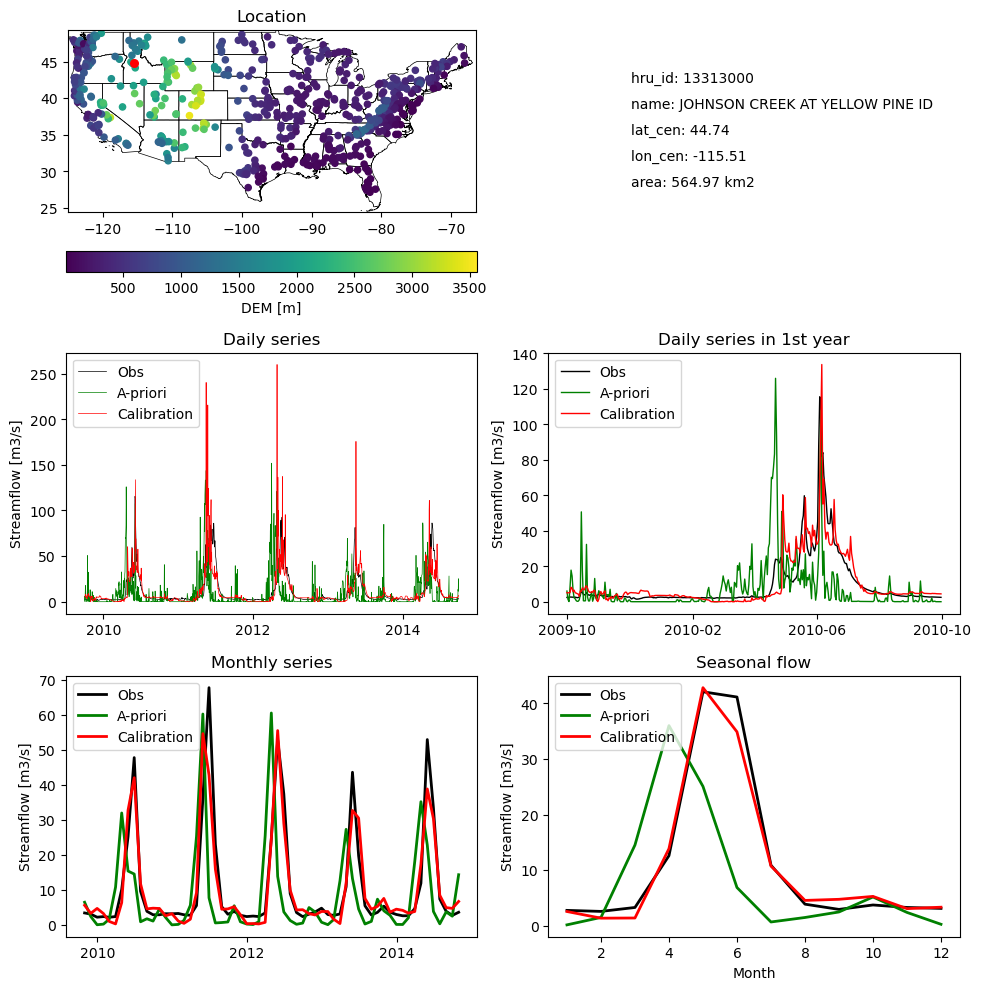

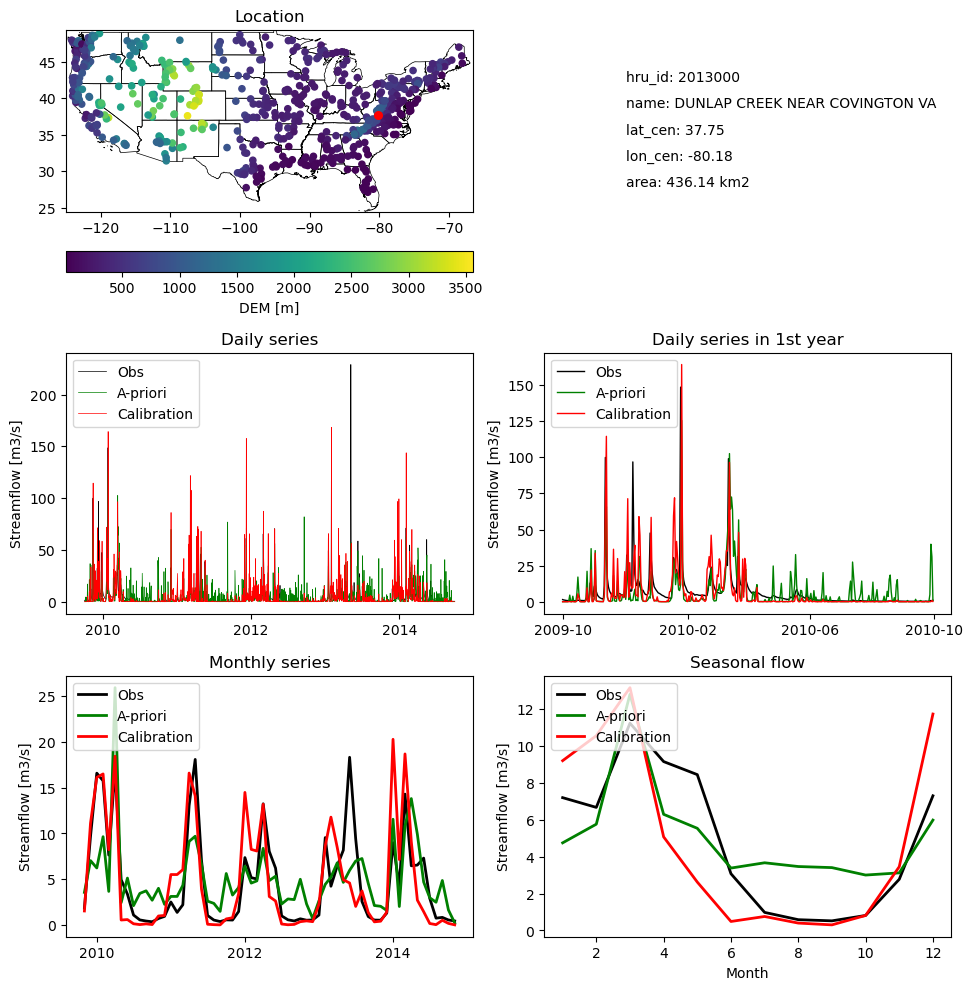

In [32]:
def save_one_basin( df_info, path0, basin):
    ds_clm, ds_clm_optmz, ds_qobs, ds_clm_m1, ds_clm_m2, ds_clm_optmz_m1, ds_clm_optmz_m2, ds_qobs_m1, ds_qobs_m2 = process_basin_data(basin, df_info)
                    
    # Plot the data
    fig = plot_basin_data(basin, df_info, ds_clm, ds_clm_optmz, ds_qobs, 
                                          ds_clm_m1, ds_clm_m2, ds_clm_optmz_m1, ds_clm_optmz_m2, 
                                          ds_qobs_m1, ds_qobs_m2,)
    plt.savefig(f'hydrographs_basin{basin}.png', dpi=600, bbox_inches='tight', pad_inches=0)

basin=592 # good example
save_one_basin( df_info, path0, basin)

basin=84 # bad example
save_one_basin( df_info, path0, basin)